In [2]:
import glob
import random
import numpy as np
import tensorflow as tf

def load_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    img = tf.cast(img, tf.float32)
    img = 1./255*img
    return img


def load_mask(file_path):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.resize(img, [128, 128])
    img = tf.cast(img, tf.bool)
    img = tf.cast(img, tf.int8)
    return img


def preprocess_image(input_img_path, target_img_path):
    input_img = load_image(input_img_path)
    target_img = load_mask(target_img_path)
    return input_img, target_img


def build_dataset(input_files: list[str], output_files: list[str], batch_size: int):
    dataset = tf.data.Dataset.from_tensor_slices((input_files, output_files))
    # dataset = dataset.shuffle(len(input_files))
    dataset = dataset.map(lambda x, y: preprocess_image(x, y))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)

    return dataset


images_path = './data/train/images/'
masks_path = './data/train/masks/'

input_img_names = glob.glob(images_path+'*.png')
output_img_names = glob.glob(masks_path+'*.png')

batch_size = 32

dataset = build_dataset(input_img_names, output_img_names, batch_size)

print(dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int8, name=None))>


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
train_size = int(0.9*dataset.cardinality().numpy())

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

print('train dataset size:', train_dataset.cardinality().numpy())
print('test dataset size:', test_dataset.cardinality().numpy())

train dataset size: 112
test dataset size: 13


In [5]:
import tensorflow as tf
from keras.layers import concatenate, Conv2D, Input, Dropout,MaxPooling2D, Conv2DTranspose


IMG_WIDTH=None
IMG_HEIGHT=None
IMG_CHANNELS=3

filters_nb=16
Dropout_value=0.3

class UNet() :
    def __init__(self):
        self.inputs= Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))

        c1 = Conv2D(filters_nb,(3,3), activation='relu', kernel_initializer='he_normal',padding='same')(self.inputs)
        # c1 = Dropout(Dropout_value)(c1)
        c1 = Conv2D(filters_nb,(3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c1)
        p1 = MaxPooling2D((2,2))(c1)

        c2 = Conv2D(filters_nb*2,(3,3), activation='relu', kernel_initializer='he_normal',padding='same')(p1)
        # c2 = Dropout(Dropout_value)(c2)
        c2 = Conv2D(filters_nb*2,(3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c2)
        p2 = MaxPooling2D((2,2))(c2)

        c3 = Conv2D(filters_nb*4,(3,3), activation='relu', kernel_initializer='he_normal',padding='same')(p2)
        # c3 = Dropout(Dropout_value)(c3)
        c3 = Conv2D(filters_nb*4,(3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c3)
        p3 = MaxPooling2D((2,2))(c3)

        c4 = Conv2D(filters_nb*8,(3,3), activation='relu', kernel_initializer='he_normal',padding='same')(p3)
        # c4 = Dropout(Dropout_value)(c4)
        c4 = Conv2D(filters_nb*8,(3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c4)
        p4 = MaxPooling2D((2,2))(c4)

        c5 = Conv2D(filters_nb*8,(3,3), activation='relu', kernel_initializer='he_normal',padding='same')(p3)
        # c5 = Dropout(Dropout_value)(c5)
        c5 = Conv2D(filters_nb*8,(3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c5)

        u6 = Conv2DTranspose(filters_nb*8,(2,2),strides=(2,2),padding='same')(c4)
        u6 = concatenate([u6,c4])
        c6 = Conv2D(filters_nb*8,(3,3), activation='relu', kernel_initializer='he_normal',padding='same')(u6)
        # c6 = Dropout(Dropout_value)(c6)
        c6 = Conv2D(filters_nb*8,(3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c6)

        u7 = Conv2DTranspose(filters_nb*4,(2,2),strides=(2,2),padding='same')(c5)
        u7 = concatenate([u7,c3])
        c7 = Conv2D(filters_nb*4,(3,3), activation='relu', kernel_initializer='he_normal',padding='same')(u7)
        # c7 = Dropout(Dropout_value)(c7)
        c7 = Conv2D(filters_nb*4,(3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c7)

        u8 = Conv2DTranspose(filters_nb*2,(2,2),strides=(2,2),padding='same')(c7)
        u8 = concatenate([u8,c2])
        c8 = Conv2D(filters_nb*2,(3,3), activation='relu', kernel_initializer='he_normal',padding='same')(u8)
        # c8 = Dropout(Dropout_value)(c8)
        c8 = Conv2D(filters_nb*2,(3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c8)

        u9 = Conv2DTranspose(filters_nb,(2,2),strides=(2,2),padding='same')(c8)
        u9 = concatenate([u9,c1])
        c9 = Conv2D(filters_nb,(3,3), activation='relu', kernel_initializer='he_normal',padding='same')(u9)
        # c9 = Dropout(Dropout_value)(c9)
        c9 = Conv2D(filters_nb,(3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c9)

        self.outputs=Conv2D(1,(1,1), activation='sigmoid')(c9)

    def create_model(self):
        return tf.keras.Model(inputs=[self.inputs,],outputs=[self.outputs,])

In [6]:
model = UNet().create_model()

model.compile(optimizer='Adam',loss='binary_crossentropy' ,metrics=['binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   448         ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   2320        ['conv2d[0][0]']                 
                                16)                                                           

In [7]:

import datetime
import tensorflow as tf


def callback_setup(checkpoint_filepath: str = "", save_logs: bool = False):
    '''Définir les callbacks du modèle 

    Args:
        checkpoint_name: définir le nom du checkpoint (le nom du checkpoint avec les paramètres initiaux et 200 epochs est "original_model"). Si laissé vide, le training est reprit à 0 à chaque fois
        save_logs: enregistrement des  logs pour tensorboard
    '''
    model_callbacks = []

    '''=== CHECKPOINT DES POIDS ==='''
    if checkpoint_filepath:
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='binary_accuracy',
            mode='max',
            save_best_only=True)
        model_callbacks.append(model_checkpoint_callback)

    '''=== LOGS ==='''
    if save_logs:
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(
            log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=False)
        model_callbacks.append(tensorboard_callback)

    return model_callbacks


checkpoint_name = "test1"

# Calcul du chemin et definition de la liste des callbacks
checkpoint_filepath = './backup/' +  checkpoint_name + '/' if checkpoint_name else ""
model_callbacks = callback_setup(checkpoint_filepath=checkpoint_filepath, save_logs=True)

In [8]:
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=(test_dataset),
                    verbose=1,
                    callbacks=model_callbacks)

Epoch 1/100
112/112 [==============================] - 24s 141ms/step - loss: 0.5170 - binary_accuracy: 0.7467 - val_loss: 0.3849 - val_binary_accuracy: 0.8363
Epoch 2/100
112/112 [==============================] - 15s 137ms/step - loss: 0.3603 - binary_accuracy: 0.8608 - val_loss: 0.2882 - val_binary_accuracy: 0.8912
Epoch 3/100
112/112 [==============================] - 16s 140ms/step - loss: 0.3201 - binary_accuracy: 0.8803 - val_loss: 0.2591 - val_binary_accuracy: 0.9037
Epoch 4/100
112/112 [==============================] - 17s 148ms/step - loss: 0.3045 - binary_accuracy: 0.8893 - val_loss: 0.2548 - val_binary_accuracy: 0.9073
Epoch 5/100
112/112 [==============================] - 17s 149ms/step - loss: 0.2804 - binary_accuracy: 0.8970 - val_loss: 0.2330 - val_binary_accuracy: 0.9153
Epoch 6/100
112/112 [==============================] - 16s 144ms/step - loss: 0.2653 - binary_accuracy: 0.9019 - val_loss: 0.2291 - val_binary_accuracy: 0.9129
Epoch 7/100
112/112 [===================

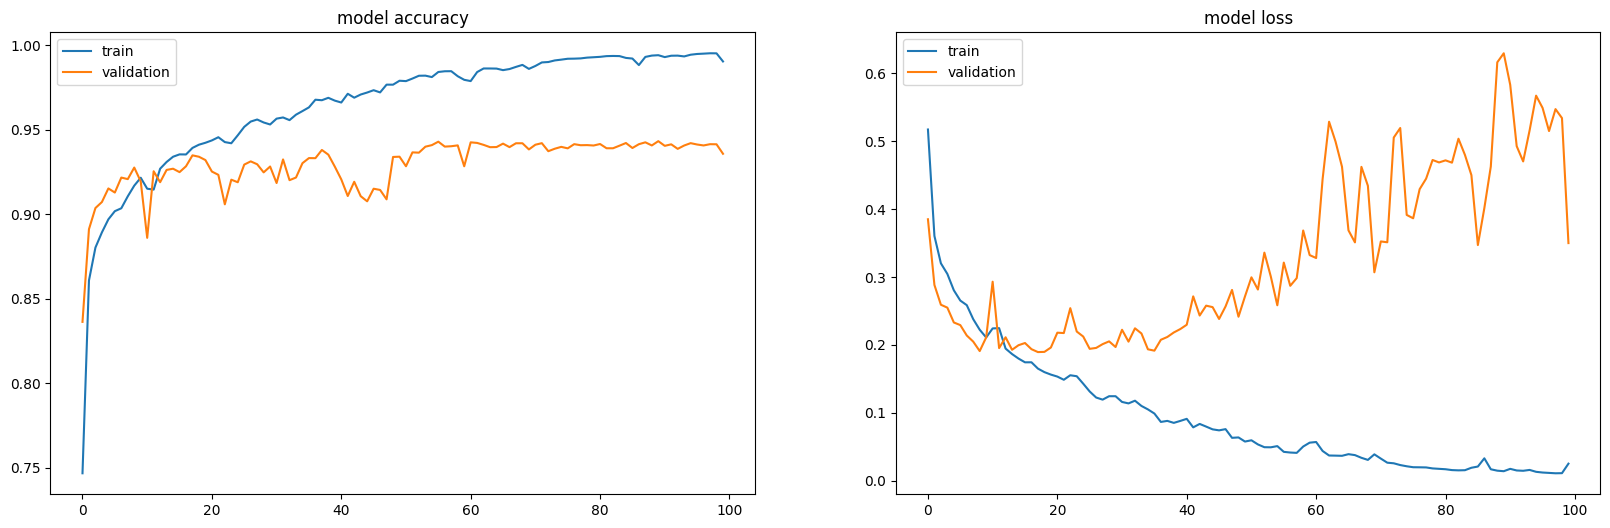

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# summarize history for accuracy


ax[0].plot(history.history['binary_accuracy'])
ax[0].plot(history.history['val_binary_accuracy'])
ax[0].set_title('model accuracy')
ax[0].legend(['train', 'validation'], loc='upper left')

# loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].legend(['train', 'validation'], loc='upper left')

# save fig
plt.savefig('./backup/' + checkpoint_name + '/train_history.png')


### Questions
In this section we investigate the impact of various architectural choices of the proposed U-Net
for semantic segmentation.
1. **Max pooling:** Max pooling has been used for down-sizing the input volume. Instead of max pooling, is it
possible to simply make use of convolution with a different stride, e.g., 2 ? How does it impact
the performance ?

2. **Skip Connections:** The skip connections have been used in the proposed architecture. Why is this important ?
Suppose that we remove these skip connections from the proposed architecture, how does it
impact the result ? Please explain your intuition. Furthermore, the current skip connections
consist of concatenating feature maps of the encoder with those of the decoder at the same
level, is it possible to make use of other alternatives, for instance addition, Max or Min operation
? Do they impact the results ? Explain.

3. **FCN and Auto-encoder:** The proposed architecture is an auto-encoder like architecture, i.e., composed of an encoder
and a decoder. Is it necessary ? Is it possible that we make use of a fully convolutional neural
network (FCN) consisting of series of convolutions from the input to the output while keeping the
image size, i.e., width and height, during all the convolutions ?

4. **Threshold for inference:** We have taken 0.5 as the threshold to decide whether to classify a pixel as salt or not. However,
this choice proves not to be the optimal in terms of precision and recall rate for pixels being
classified salt. Could you explain how we should define the precision and recall rate in our
business case. Could you propose a strategy to improve both precision and recall ?


### Tests
test1: stride = 1
